In [18]:
from __future__ import division, print_function
import time
import os

# Third-party
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.signal import argrelmin

# Custom
import gary.coordinates as gc
import gary.dynamics as gd
import gary.integrate as gi
import gary.io as io
import gary.potential as gp
from gary.units import galactic

from streammorphology.freqmap import estimate_dt_nsteps
from streammorphology.ensemble.core import do_the_kld, create_ball

### Stream-fanning orbit

In [10]:
x0 = np.array([8.312877511, 0.242593717, 16.811943627])
v0 = ([-52.429087, -96.697363, -8.156130]*u.km/u.s).to(u.kpc/u.Myr).value
w0 = np.append(x0,v0)

In [11]:
potential = gp.LM10Potential()

In [12]:
E = potential.total_energy(w0[:3], w0[3:])[0]

# find where it intersects X-Z plane
t,w = potential.integrate_orbit(w0, dt=0.5, nsteps=10000, Integrator=gi.DOPRI853Integrator)
ymin_ix = argrelmin(np.abs(w[:,0,1]))[0]
xz_ix = np.where((w[:,0,0] > 0) & (w[:,0,0] > 2))[0]

for i in ymin_ix:
    if i in xz_ix:
        print(i)
        break
        
print("Pal5 hits X-Z plane at: ({0:.2f},{1:.2f})".format(w[i,0,0], w[i,0,2]))
print("Energy: {0:.4f}".format(E))

5
Pal5 hits X-Z plane at: (8.18,16.79)
Energy: 0.0720


In [38]:
dt,nsteps = estimate_dt_nsteps(potential, w0, nperiods=10000, nsteps_per_period=512)
dt,nsteps

(0.4179181530510605, 10240000)

In [31]:
# path = "/Users/adrian/projects/morphology/output/pal5/"
# if not os.path.exists(os.path.join(path,"le.npy")):
#     a = time.time()
#     le,t,w = gd.fast_lyapunov_max(w0, potential, dt, nsteps)
#     print("Took {0:.2f} seconds".format(time.time() - a))

#     np.save(os.path.join(path,"le.npy"), le)
#     np.save(os.path.join(path,"t.npy"), t)
#     np.save(os.path.join(path,"w.npy"), w)

# le = np.load(os.path.join(path,"le.npy"))
# t = np.load(os.path.join(path,"t.npy"))
# w = np.load(os.path.join(path,"w.npy"))

In [32]:
a = time.time()
le,t,w = gd.fast_lyapunov_max(w0, potential, dt, nsteps, d0=1E-7)
print("Took {0:.2f} seconds".format(time.time() - a))

Took 81.98 seconds


ERROR! Session/line number was not unique in database. History logging moved to new session 3721


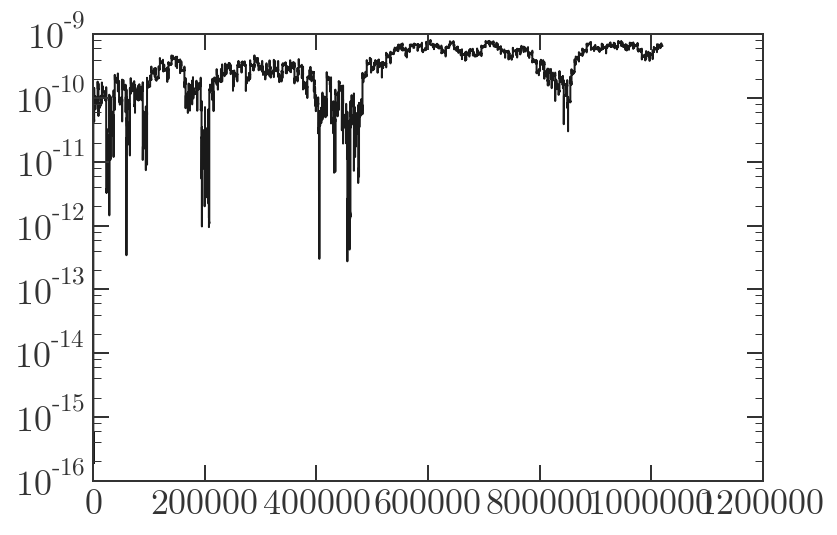

In [37]:
E = potential.total_energy(w[:,0,:3], w[:,0,3:])
plt.semilogy(np.abs((E[1:]-E[0])/E[0]), marker=None, drawstyle='steps')

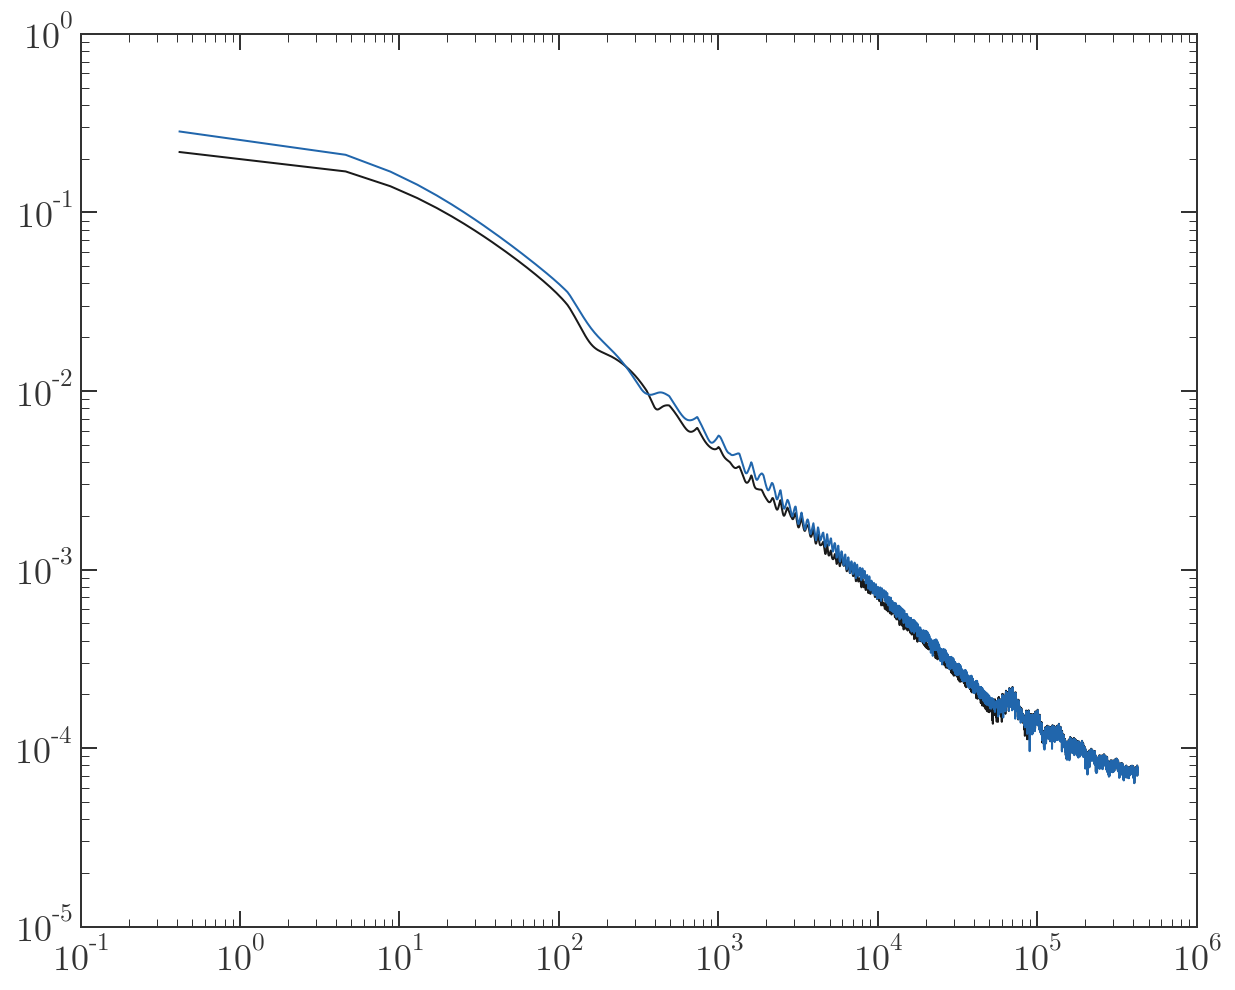

In [34]:
plt.figure(figsize=(10,8))
plt.loglog(t[1:-10:10], le, marker=None)

In [22]:
# fig = gd.plot_orbits(w[::10,0], marker=',', alpha=0.5, linestyle='none') 

## Pal 5 Lyapunov time

In [25]:
1 / le[-1000:,0].mean()

4748.1778800226029

## NAFF

In [16]:
naff = gd.NAFF(t[:nsteps//2+1])

In [17]:
# new_w = gc.poincare_polar(w[:nsteps//2+1,0])
new_w = w[:nsteps//2+1,0]
fs = [(new_w[:,i] + 1j*new_w[:,i+3]) for i in range(3)]
freqs1,d,nv = naff.find_fundamental_frequencies(fs)

In [18]:
# new_w = gc.poincare_polar(w[nsteps//2:,0])
new_w = w[nsteps//2:,0]
fs = [(new_w[:,i] + 1j*new_w[:,i+3]) for i in range(3)]
freqs2,d,nv = naff.find_fundamental_frequencies(fs)

In [19]:
T = np.abs(2*np.pi / freqs1)
T

array([ 399.99463978,  427.86360725,  460.04845381])

In [93]:
nperiods = nsteps * dt / T
nperiods

array([ 278.1700503 ,  260.05139765,  241.85828285])

In [94]:
np.log10(np.abs((freqs2-freqs1)/freqs1)/(nperiods/2))

array([-6.37402464, -5.74131009, -5.65234207])

## KLD

In [25]:
ball_w0 = create_ball(w0, potential, N=1000, m_scale=2.5E4)
kld_dt,kld_nsteps = estimate_dt_nsteps(potential, w0, nperiods=50, nsteps_per_period=100)

In [26]:
kld_t,kld,mean_dens = do_the_kld(256, ball_w0, potential, kld_dt,kld_nsteps, 
                                 kde_bandwidth=10., density_thresholds=None) 

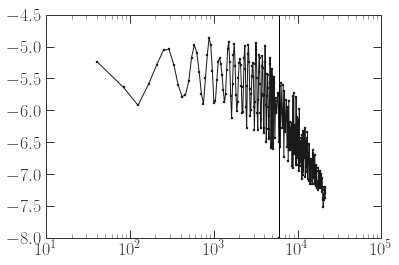

In [29]:
# plt.loglog(kld_t / T.mean(), mean_dens)
plt.semilogx(kld_t, kld)
plt.axvline(6000)

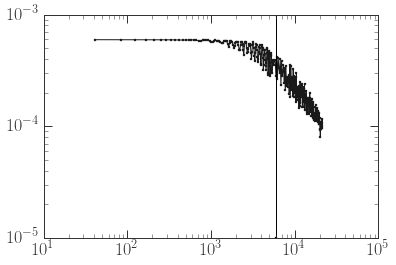

In [30]:
plt.loglog(kld_t, mean_dens)
plt.axvline(6000)